Import Packages

In [1]:
import os
import torch
import torchvision
#import tarfile
#from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt

File Path

In [2]:
Fea_train_path = 'data/npy/CNN/Fea_train_mfcc_fold0_50.npy'
Lab_train_path = 'data/npy/CNN/Lab_train_mfcc_fold0_50.npy'
Fea_val_path = 'data/npy/CNN/Fea_val_mfcc_fold0_50.npy'
Lab_val_path = 'data/npy/CNN/Lab_val_mfcc_fold0_50.npy'
Fea_test_path = 'data/npy/CNN/test_mfcc50.npy'


<b>Loading data into tensor dataset <br></b>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 50, 1290]) tensor(0)


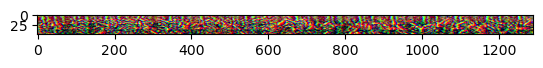

In [3]:
batch_size = 10

################# Load data ##############
Fea_train = np.load(Fea_train_path)
Lab_train = np.load(Lab_train_path)

Fea_val = np.load(Fea_val_path)
Lab_val = np.load(Lab_val_path)

Fea_test = np.load(Fea_test_path)
################# Load data ##############

train_dataset = TensorDataset(torch.tensor(Fea_train, dtype=torch.float32), torch.tensor(Lab_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(Fea_val, dtype=torch.float32), torch.tensor(Lab_val, dtype=torch.long))
test_tensor = torch.tensor(Fea_test, dtype = torch.float32)

tmp_fea, tmp_lab = train_dataset[0]
print (tmp_fea.shape, tmp_lab)
plt.imshow(tmp_fea.permute(1, 2, 0))

train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=4, pin_memory=True)

Convolution NN<br>
refer to https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch

In [4]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

class AudioClassificationBase(nn.Module):
    def training_step(self, batch):
        tmp_fea, tmp_lab = batch
        out = self(tmp_fea)         # trigger __call__ inside the nn.Module for forward propagation
        loss = F.cross_entropy(out, tmp_lab)
        return loss
    
    def validation_step(self, batch):
        tmp_fea, tmp_lab = batch
        out = self(tmp_fea)
        loss = F.cross_entropy(out, tmp_lab)
        acc = accuracy(out, tmp_lab)
        return {'val_loss': loss.detach(), 'val_acc': acc} # no gradient 
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [5]:
class Cifar10CnnModel(AudioClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 25 x 624

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 12 x 322

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 6 x 161

            nn.Flatten(), 
            nn.Linear(256*6*161, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        

    def forward(self, xb):
        return self.network(xb)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
model = Cifar10CnnModel()
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [12]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
    
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [13]:
model = to_device(Cifar10CnnModel(), device)

In [14]:
evaluate(model,val_dl)

/home/dawnmoon/miniconda3/envs/Leo_pytch/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
/home/dawnmoon/miniconda3/envs/Leo_pytch/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


{'val_loss': 2.3023319244384766, 'val_acc': 0.10000000149011612}

In [14]:
import random
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

num_epoches = 100
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epoches, lr, model, train_dl, val_dl, opt_func)

/home/dawnmoon/miniconda3/envs/Leo_pytch/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
/home/dawnmoon/miniconda3/envs/Leo_pytch/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [0], train_loss: 2.7999, val_loss: 2.0082, val_acc: 0.2200
Epoch [1], train_loss: 1.9877, val_loss: 2.1325, val_acc: 0.3300
Epoch [2], train_loss: 1.6959, val_loss: 1.6843, val_acc: 0.4000
Epoch [3], train_loss: 1.5155, val_loss: 2.0249, val_acc: 0.3000
Epoch [4], train_loss: 1.4599, val_loss: 1.6113, val_acc: 0.4500
Epoch [5], train_loss: 1.3698, val_loss: 1.6409, val_acc: 0.4000
Epoch [6], train_loss: 1.1305, val_loss: 1.4756, val_acc: 0.5100
Epoch [7], train_loss: 0.8470, val_loss: 1.6646, val_acc: 0.4800
Epoch [8], train_loss: 0.5351, val_loss: 2.3795, val_acc: 0.4400
Epoch [9], train_loss: 0.3896, val_loss: 1.9676, val_acc: 0.5100
Epoch [10], train_loss: 0.1807, val_loss: 2.9066, val_acc: 0.4100
Epoch [11], train_loss: 0.1712, val_loss: 2.9248, val_acc: 0.4200
Epoch [12], train_loss: 0.3296, val_loss: 3.3378, val_acc: 0.1800
Epoch [13], train_loss: 0.8208, val_loss: 2.5606, val_acc: 0.4200
Epoch [14], train_loss: 0.2471, val_loss: 2.4388, val_acc: 0.4800
Epoch [15], train_lo

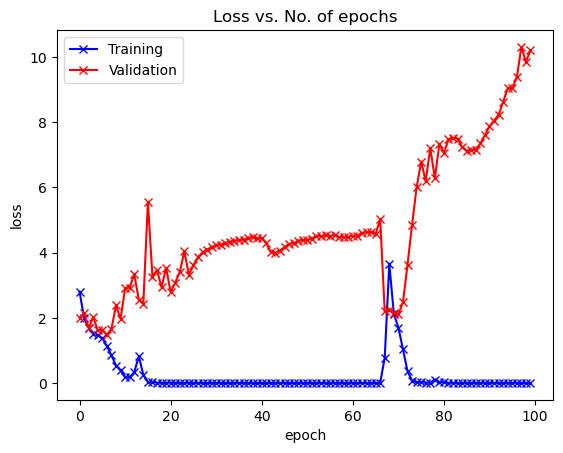

In [15]:
train_losses = [x.get('train_loss') for x in history]
val_losses = [x['val_loss'] for x in history]
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs');

In [43]:
class Module:
    def __call__(self, *input, **kwargs):
        # Prepares the module for operation (e.g., setting up hooks)
        result = self.forward(*input, **kwargs)  # This dynamically calls `forward` of the actual class
        return result
    
class test(Module):
    def test_func(self, input):
        return (self(input))

    def forward(self, tmp_input):
        return tmp_input *2
    
a = test()
a.test_func(2)

4

In [33]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

kernel_noPad_noStr(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

Build the MLP

In [19]:
#scaler = StandardScaler() # not necessary if you do normalization before

train_dataset = TensorDataset(torch.tensor(Features_normalized, dtype=torch.float32), torch.tensor(Labels, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(Val_Features_norm, dtype=torch.float32), torch.tensor(Val_Labels, dtype=torch.long))

batch_size = 40
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size)

# input layer
# number of features
input_size = Features_normalized.shape[1]
# number of hidden layer's nodes
hidden_size = 64
output_size = Labels_array.shape[1]

model = MLP(input_size, hidden_size, output_size)
print (model)

optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.001)


MLP(
  (fc1): Linear(in_features=300, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (cost): CrossEntropyLoss()
)


Train the MLP

100%|██████████| 1000/1000 [00:23<00:00, 42.91it/s]


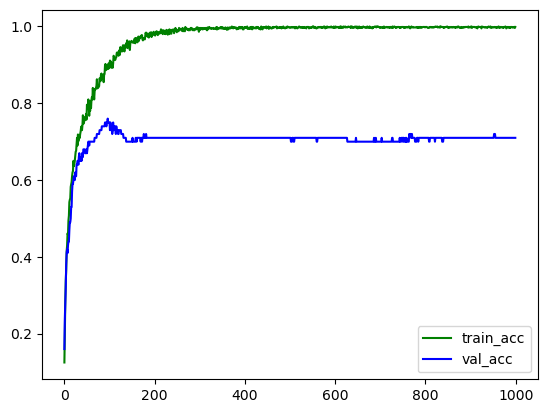

In [20]:
Epochs = 1000
train_acc = []
val_acc = []
for ep in tqdm(range(Epochs)):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader:
        # remove the gradient from the preious batch to remove bias
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = model.cost(outputs,targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_acc.append(correct_train/total_train)
    #print (f"Epoch{ep+1}: Train loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc: .2f}")
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = model.cost(outputs, targets)
            val_loss += loss.item()
            _,predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    val_acc.append(correct_val/total_val)
    #print (f"Epoch{ep+1}: Val loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc: .2f}")

train_acc = np.array(train_acc)
val_acc = np.array(val_acc)
plt.plot(range(Epochs), train_acc, 'g', label = 'train_acc')
plt.plot(range(Epochs), val_acc, 'b', label = 'val_acc')
plt.legend()

Get the Prediction

In [21]:
test_tensor = torch.tensor(test_Features_norm, dtype = torch.float32)

with torch.no_grad():
    output = model(test_tensor)
    torch.max(outputs, 1)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)

genra = ['blues', ' classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
kaggle = pd.read_csv('data/data/test/list_test.txt', header = None)
for i in tqdm(range(100)):
    kaggle.loc[i,'class'] = genra[predicted_class[i]]

kaggle.to_csv('CSV/kaggle_mfcc50_delta_delta_MLP_1000.csv')
kaggle

100%|██████████| 100/100 [00:00<00:00, 9945.00it/s]


,0,class
0,test.00596.au,hiphop
1,test.02436.au,reggae
2,test.02930.au,blues
3,test.03364.au,country
4,test.03550.au,country
...,...,...
95,test.95763.au,metal
96,test.96483.au,reggae
97,test.97080.au,classical
98,test.97638.au,country


In [87]:
predicted_class

tensor([4, 8, 1, 2, 2, 5, 8, 2, 1, 6, 5, 1, 2, 4, 4, 2, 5, 9, 0, 1, 8, 3, 7, 7,
        3, 9, 1, 2, 4, 4, 6, 8, 9, 1, 4, 3, 9, 3, 2, 1, 9, 6, 5, 4, 1, 4, 6, 1,
        8, 8, 7, 6, 5, 1, 7, 1, 6, 6, 9, 7, 2, 7, 8, 0, 7, 3, 4, 2, 9, 4, 7, 3,
        1, 5, 1, 8, 6, 8, 9, 4, 3, 2, 5, 6, 6, 3, 7, 1, 2, 5, 8, 3, 5, 2, 1, 6,
        8, 1, 2, 3])